# Assignment 3

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model](https://open.spotify.com/track/4R3AU2pjv8ge2siX1fVbZs?si=b2712f32da0e4358) or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [3]:
# Load the libraries as required.
import pandas as pd 
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer  
from sklearn.pipeline import Pipeline  
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge  
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR  
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor 
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, explained_variance_score, max_error, make_scorer 


In [4]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()

# Filter out rows with zero or negative values in the target variable
fires_dt = fires_dt[fires_dt['area'] > 0]

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


# Get X and Y

Create the features data frame and target data.

In [70]:
X = fires_dt.drop(columns='area')
Y = fires_dt['area']


In [77]:
#use a train-test split of 70%:30%, set the random state function to 42
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)


Y contains zero or negative values. These will be filtered out.


In [45]:
# Check for zero or negative values in Y
if (Y <= 0).any():
    print("Warning: Y contains zero or negative values. Consider filtering them out or applying a different transformation.")
    
    # Option 1: Filter out zero and negative values
    Y_filtered = Y[Y > 0]

    # Option 2: Alternatively, you could set zero values to a small positive number
    # Y = Y.replace(0, 0.001)  # Replace zero with a small value if needed

    # Note: If you filter Y, you need to filter X correspondingly
    X_filtered = X[Y > 0]  # Keep only the rows corresponding to the filtered Y

    # Proceed with the filtered data
    Y_transformed = np.log1p(Y_filtered)  # Apply log transformation to filtered Y
else:
    # If there are no invalid values, you can directly apply the log transformation
    Y_transformed = np.log1p(Y)

# Now, Y_transformed can be used in your model training
print("Transformed Y:", Y_transformed)

Transformed Y: 138    0.307485
139    0.357674
140    0.385262
141    0.438255
142    0.476234
         ...   
509    1.153732
510    0.357674
512    2.006871
513    4.012592
514    2.498152
Name: area, Length: 270, dtype: float64


# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [78]:
#define non-target columns into numerical ones and categorical ones first
num_cols = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
cat_cols = ['month', 'day']

#scale and impute numerical and categorical columns before creating preproc1 and preproc2
pipe_num = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='median')), 
        ('scaler', StandardScaler()),  
    ]
)

pipe_cat = Pipeline(
    [
        ('imputer', SimpleImputer(strategy='most_frequent')),  
        ('onehot', OneHotEncoder(handle_unknown='ignore', drop='if_binary')),
    ]
)

#create preproc1
preproc1 = ColumnTransformer([
    ('num_transform', pipe_num, num_cols), 
    ('cat_transform', pipe_cat, cat_cols)
])

preproc1

ColumnTransformer(transformers=[('num_transform',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transform',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [98]:
pipe_num_2 = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('standardscaler', StandardScaler()),  
    ('log_transform', FunctionTransformer(lambda x: np.log1p(x.clip(min=1e-10)), validate=False)) 
])



preproc2 = ColumnTransformer(
    transformers=[
        ('num_transform', pipe_num_2, num_cols),  # Apply numeric transformations
        ('cat_transform', pipe_cat, cat_cols)    # Apply categorical transformations
    ]
)

preproc2



ColumnTransformer(transformers=[('num_transform',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('standardscaler',
                                                  StandardScaler()),
                                                 ('log_transform',
                                                  FunctionTransformer(func=<function <lambda> at 0x32f6b5160>))]),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_transform',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('onehot',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='ignore'))]),
                                 ['month', 'day'])])

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [100]:
# Pipeline A = preproc1 + baseline

#define a baseline regressor using ridge
baseline_regressor = Ridge()

#create pipeline A
pipeline_A = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])

In [101]:
# Pipeline B = preproc2 + baseline
#create pipeline B
pipeline_B = Pipeline(steps=[
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])


In [103]:
# Pipeline C = preproc1 + advanced model

#define an advanced regressor using SVR
advanced_regressor = SVR()

#create pipeline C
pipeline_C = Pipeline([
    ('preprocessing', preproc1), 
    ('regressor', advanced_regressor)
])


In [104]:
# Pipeline D = preproc2 + advanced model
# create pipeline D
pipeline_D = Pipeline([
    ('preprocessing', preproc2),  
    ('regressor', advanced_regressor)
])
    

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('num_transform',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['coord_x',
                                                                          'coord_y',
                                                                          'ffmc',
                                                                          'dmc',
                                                                          'dc',
                                                                          'isi',
                                                                          'temp',
                                                                          'rh',
                                                                          'wind',
                                                                          'rain']),
                                                                        ('cat_transform',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='if_binary',
                                                                                                        handle_unknown='ignore'))]),
                                                                         ['month',
                                                                          'day'])])),
                                       ('regressor', Ridge())]),
             param_grid={'regressor__alpha': [0.1, 1.0, 10.0, 100.0]},
             scoring='neg_mean_squared_error')

In [117]:
#Define the hyperparameter grids
#the grid for ridge
param_grid_baseline = {
    'regressor__alpha': [0.1,1.0, 10.0, 100.0,1000.0,10000.0]  
}
#the grid for svr
param_grid_advanced = {
    'regressor__C': [0.1,1.0, 10.0, 100.0,1000.0,10000.0]  
}

#gridsearch on pipeline A
grid_A = GridSearchCV(pipeline_A, param_grid_baseline, cv=10, scoring='neg_mean_squared_error')
grid_A.fit(X_train, Y_train)
print(f"Best parameters for Pipeline A: {grid_A.best_params_}")


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

Best parameters for Pipeline A: {'regressor__alpha': 1000.0}
Best parameters for Pipeline B: {'regressor__alpha': 100.0}
Starting GridSearch for Pipeline C...


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as al

Best parameters for Pipeline C: {'regressor__C': 0.1}
Starting GridSearch for Pipeline D...
Best parameters for Pipeline D: {'regressor__C': 100.0}
Model fitting complete.


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [118]:
#GridSearch on pipeline B
grid_B = GridSearchCV(pipeline_B, param_grid_baseline, cv=10, scoring='neg_mean_squared_error')
grid_B.fit(X_train, Y_train)
print(f"Best parameters for Pipeline B: {grid_B.best_params_}")


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Best parameters for Pipeline B: {'regressor__alpha': 1000.0}


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


In [119]:
#gridsearch on pipeline C
grid_C = GridSearchCV(pipeline_C, param_grid_advanced, cv=10, scoring='neg_mean_squared_error')
grid_C.fit(X_train, Y_train)
print(f"Best parameters for Pipeline C: {grid_C.best_params_}")



Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Best parameters for Pipeline C: {'regressor__C': 0.1}


In [131]:
#gridsearch on pipeline D
grid_D = GridSearchCV(pipeline_D, param_grid_advanced, cv=10, scoring='neg_mean_squared_error')
grid_D.fit(X_train, Y_train)
print(f"Best parameters for Pipeline D: {grid_D.best_params_}")

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


Best parameters for Pipeline D: {'regressor__C': 100.0}


# Evaluate

+ Which model has the best performance?

In [156]:
#make predictions using the 4 models
y_pred_A = grid_A.best_estimator_.predict(X_test)
y_pred_B = grid_B.best_estimator_.predict(X_test)
y_pred_C = grid_C.best_estimator_.predict(X_test)
y_pred_D = grid_D.best_estimator_.predict(X_test)

#calculate RMSE for each 
rmse_results = {
    'Pipeline A': np.sqrt(mean_squared_error(Y_test, y_pred_A)),
    'Pipeline B': np.sqrt(mean_squared_error(Y_test, y_pred_B)),
    'Pipeline C': np.sqrt(mean_squared_error(Y_test, y_pred_C)),
    'Pipeline D': np.sqrt(mean_squared_error(Y_test, y_pred_D))
}

rmse_results_df = pd.DataFrame(rmse_results.items(), columns=['Model', 'RMSE'])
print(rmse_results_df)

best_model_rmse = rmse_results_df.loc[rmse_results_df['RMSE'].idxmin()]
print(f"The best model is: {best_model_rmse['Model']}")

        Model       RMSE
0  Pipeline A  89.283610
1  Pipeline B  89.509106
2  Pipeline C  89.612568
3  Pipeline D  90.236428
The best model is: Pipeline A


Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


# Export

+ Save the best performing model to a pickle file.

In [155]:
import pickle

# Extract the best model from gridsearch for pipeline A
best_model = grid_A.best_estimator_

# Save the model to a pickle file
with open('best_model_pipeline_A.pkl', 'wb') as model_file:
    pickle.dump(best_model, model_file)

# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros


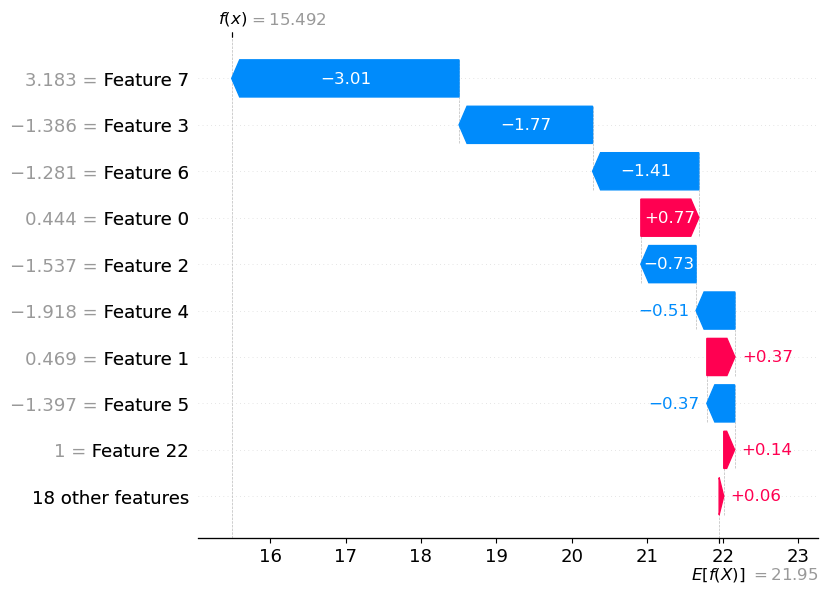

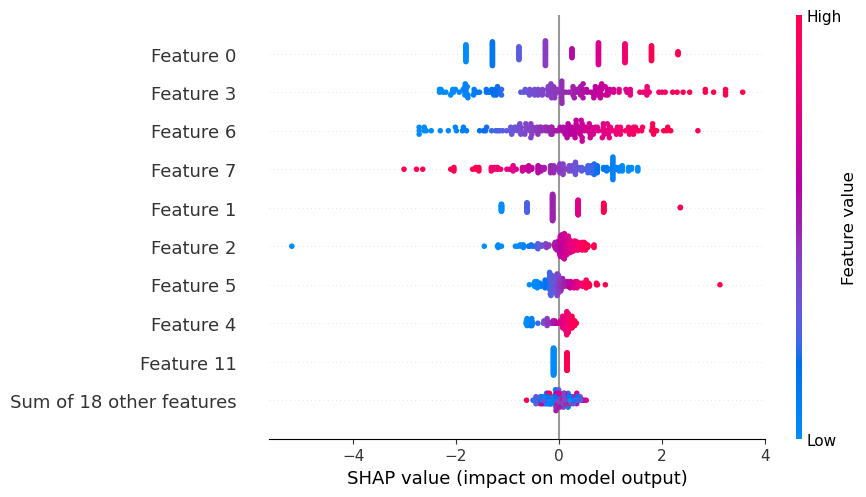

In [163]:
import shap

best_model = grid_A.best_estimator_

X_test_transformed = best_model.named_steps['preprocessing'].transform(X_test)

explainer = shap.Explainer(best_model.named_steps['regressor'], X_test_transformed)

shap_values = explainer(X_test_transformed)


#Shap value for 1 oberservation
shap.plots.waterfall(shap_values[0]) 
#Answer after observation: for the specific observation, the most important feature is Feature 7.

In [ ]:
#In general, for all cases
shap.plots.beeswarm(shap_values)  
#Answer after observation: in general, the most important feature is Feature 0.

#Question: Which features whould you remove? How would you test?
#Answer: I'd remove the features low on the Beeswarm's Y-axis and with a narrow X-axis spread. To test, I'd train another model after removing those selected features from the dataset and compare the performance metrics.


*(Answer here.)*

## Criteria

The [rubric](./assignment_3_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-3`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_3.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at `#cohort-3-help`. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.